In [51]:
import pandas as pd
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

**Data Loading (OpenFoodFacts)**


In [3]:
#url = "https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv.gz"
#df = pd.read_csv(url, compression='gzip', sep='\t', low_memory=False, nrows=100000)



In [16]:
url = "https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv.gz"

df = pd.read_csv(url, compression='gzip', sep='\t', low_memory=False, nrows=300000)

df = df[['code', 'product_name', 'brands', 'categories', 'nutriscore_grade', 'nova_group', 'ingredients_text']]

print("Valeurs uniques dans nutriscore_grade :")
print(df['nutriscore_grade'].value_counts(dropna=False))

print("\n Valeurs uniques dans nova_group :")
print(df['nova_group'].value_counts(dropna=False))


🔍 Valeurs uniques dans nutriscore_grade :
nutriscore_grade
unknown           151091
e                  49331
d                  33581
a                  24415
c                  24339
b                  13737
not-applicable      2589
NaN                  917
Name: count, dtype: int64

🔍 Valeurs uniques dans nova_group :
nova_group
NaN    144276
4.0    111506
3.0     24984
1.0     15962
2.0      3272
Name: count, dtype: int64


In [17]:
df.head()

,code,product_name,brands,categories,nutriscore_grade,nova_group,ingredients_text
0,54,Limonade artisanale a la rose,NaN,NaN,unknown,NaN,NaN
1,63,CIABATTA OLIVE,EDEKA,NaN,unknown,NaN,"Weizenmehl, Rapsöl, Speisesalz, 1,7% Meersalz,..."
2,114,Chocolate n 3,Jeff de Bruges,NaN,unknown,NaN,NaN
3,1,Protein Coffee Caramem,Bodylab,za,unknown,4.0,"beef gelatin, glycerin, water, natural lemon f..."
4,105,Paleta gran reserva - Sierra nevada-,AdvoCare,"Bebidas y preparaciones de bebidas, Bebidas",unknown,4.0,"Thiamin, Biotin, Chromium, Garcinia cambogia f..."


In [19]:
df = df.dropna(subset=['product_name', 'categories', 'nutriscore_grade', 'nova_group'])

valid_nutriscores = ['a', 'b', 'c', 'd', 'e']
df = df[df['nutriscore_grade'].str.lower().isin(valid_nutriscores)]


df['nova_group'] = df['nova_group'].astype(float).astype(int)
df = df[df['nova_group'].isin([1, 2, 3, 4])]


df['nutriscore_grade'] = df['nutriscore_grade'].str.lower().str.strip()
df['categories'] = df['categories'].str.lower()
df['product_name'] = df['product_name'].str.strip()


df = df.drop_duplicates(subset=['code'])


df = df[~df['product_name'].str.lower().isin(['product', 'unknown', 'no name'])]

In [20]:
print(f" Nombre de produits finaux : {len(df)}")
print(" NutriScore distribution :")
print(df['nutriscore_grade'].value_counts())
print("\n NOVA distribution :")
print(df['nova_group'].value_counts())

 Nombre de produits finaux : 129056
 NutriScore distribution :
nutriscore_grade
e    44746
d    29779
c    21368
a    21351
b    11812
Name: count, dtype: int64

 NOVA distribution :
nova_group
4    89839
3    22712
1    14126
2     2379
Name: count, dtype: int64


In [12]:
#df = df.drop_duplicates(subset=['code'])

**Feature engineering**

In [21]:
# Colors
def get_nutri_nova_color(nutriscore, nova):
    if nutriscore in ['a', 'b'] and nova in [1, 2]:
        return 'green'
    elif nutriscore == 'c' or nova == 3:
        return 'orange'
    else:
        return 'red'
df['color'] = df.apply(lambda row: get_nutri_nova_color(row['nutriscore_grade'], row['nova_group']), axis=1)


In [22]:
print("Répartition des couleurs nutritionnelles :")
print(df['color'].value_counts())


Répartition des couleurs nutritionnelles :
color
red       77448
orange    40316
green     11292
Name: count, dtype: int64


**testing a scanned product**

In [25]:
# simulation de scan coca light

barcode = '5449000000996'  # Coca-Cola Light
product = df[df['code'] == int(barcode)]

if not product.empty:
    row = product.iloc[0]
    print(" produit scanné :", row['product_name'])
    print(" marque :", row['brands'])
    print(" catégories :", row['categories'])
    print(" nutriScore :", row['nutriscore_grade'].upper())
    print("NOVA :", row['nova_group'])
    print("Couleur attribuée :", row['color'])
else:
    print(" product not found in the dataset")


 product not found in the dataset


In [36]:
# random product
random_product = df.sample(1).iloc[0]

print("produit scanné :", random_product['product_name'])
print("marque :", random_product['brands'])
print("catégories :", random_product['categories'])
print("NutriScore :", random_product['nutriscore_grade'].upper())
print("NOVA :", random_product['nova_group'])
print("Couleur attribuée :", random_product['color'])




produit scanné : Ripe Plantains Maduros
marque : Goya
catégories : undefined
NutriScore : C
NOVA : 3
Couleur attribuée : orange


In [37]:
# random product forcing a category

while True:
    random_product = df.sample(1).iloc[0]
    if (
        pd.notna(random_product['categories']) and
        len(random_product['categories'].split(',')) >= 1 and
        random_product['color'] == 'red'
    ):
        break

print("produit scanné :", random_product['product_name'])
print("marque :", random_product['brands'])
print("catégories :", random_product['categories'])
print("nutriScore :", random_product['nutriscore_grade'].upper())
print("NOVA :", random_product['nova_group'])
print("couleur attribuée :", random_product['color'])


produit scanné : Spartan, cranberry grape, 100% juice
marque : Spartan
catégories : plant-based foods and beverages, beverages, plant-based beverages
nutriScore : D
NOVA : 4
couleur attribuée : red


**Fonction de recommandation**

In [39]:
def recommend_better_product(input_product, df):
    category_list = input_product['categories'].split(',')
    if not category_list:
        return None

    main_category = category_list[0].strip()

    same_category = df[df['categories'].str.contains(main_category, na=False)]
    better_products = same_category[same_category['color'] == 'green']

    if not better_products.empty:
        return better_products.sample(1).iloc[0]
    else:
        return None


In [40]:
# test

if random_product['color'] == 'red':
    recommendation = recommend_better_product(random_product, df)
    if recommendation is not None:
        print("\n recommanded product :")
        print(" name :", recommendation['product_name'])
        print("brand :", recommendation['brands'])
        print("category :", recommendation['categories'])
        print(" NutriScore :", recommendation['nutriscore_grade'].upper())
        print("NOVA :", recommendation['nova_group'])
        print(" Couleur attribuée :", recommendation['color'])
    else:
        print("\n NO BETTER PRODUCTS FOUND")




 recommanded product :
 name : Mango chunks
brand : nan
category : plant-based foods and beverages, plant-based foods, fruits and vegetables based foods, fruits based foods
 NutriScore : A
NOVA : 1
 Couleur attribuée : green


**recommandation model based on the product's name**

In [42]:
green_df = df[df['color'] == 'green'].reset_index(drop=True)

vectorizer = TfidfVectorizer(stop_words='english')
green_vectors = vectorizer.fit_transform(green_df['product_name'])

In [43]:
def recommend_similar_product(model_product_name):
    query_vec = vectorizer.transform([model_product_name])
    similarities = cosine_similarity(query_vec, green_vectors)
    best_match_idx = similarities.argmax()

    return green_df.iloc[best_match_idx]


In [45]:
def show_top_similar_products(model_product_name, top_n=5):
    query_vec = vectorizer.transform([model_product_name])
    similarities = cosine_similarity(query_vec, green_vectors).flatten()
    top_indices = similarities.argsort()[::-1][:top_n]
    top_scores = similarities[top_indices]
    top_products = green_df.iloc[top_indices]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_scores, y=top_products['product_name'], palette='Greens_d')
    plt.xlabel('Similarité')
    plt.ylabel('Produit recommandé')
    plt.title(f'Top {top_n} recommandations pour : "{model_product_name}"')
    plt.xlim(0, 1)
    plt.show()


In [44]:
if random_product['color'] == 'red':
    print("\n utilisation du modèle de reco basé sur le nom")
    recommendation = recommend_similar_product(random_product['product_name'])

    print("\n Produit recommandé :")
    print("Nom :", recommendation['product_name'])
    print("Marque :", recommendation['brands'])
    print("Catégories :", recommendation['categories'])
    print("NutriScore :", recommendation['nutriscore_grade'].upper())
    print("NOVA :", recommendation['nova_group'])
    print(" Couleur attribuée :", recommendation['color'])



 utilisation du modèle de reco basé sur le nom

 Produit recommandé :
Nom : 100% cranberry juice
Marque : Langer Juice Company  Inc.
Catégories : plant-based foods and beverages, beverages, plant-based beverages
NutriScore : B
NOVA : 1
 Couleur attribuée : green


<ipython-input-45-2218365517>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_products['product_name'], palette='Greens_d')


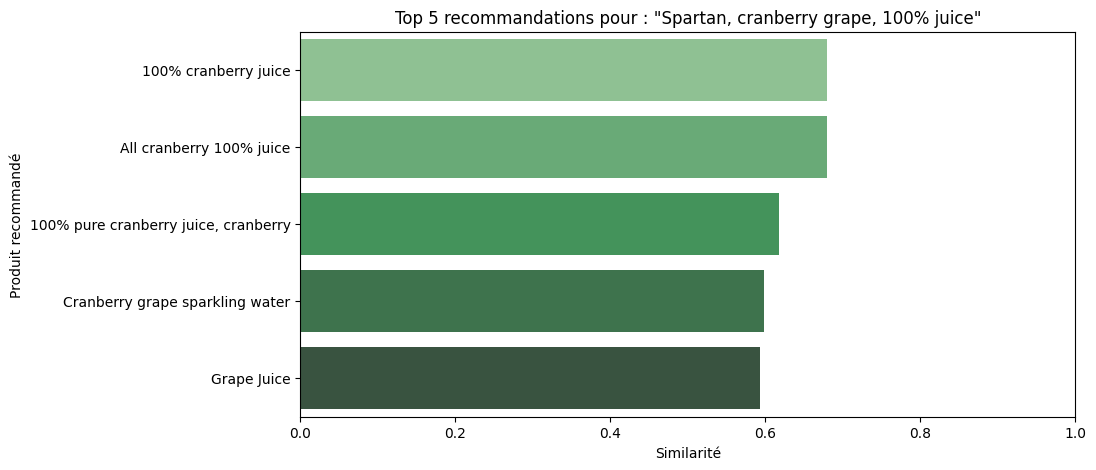

In [46]:
show_top_similar_products(random_product['product_name'], top_n=5)

In [48]:
# export vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [49]:
from google.colab import files
files.download('vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
green_df.to_csv('green_df.csv', index=False)
from google.colab import files
files.download('green_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
sparse.save_npz('green_vectors.npz', green_vectors)
files.download('green_vectors.npz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>